# Assignment 1

**Objective:**  
This assignment tests your algorithmic thinking skills. You may use any A.I. tools or resources to assist you in completing this coding assignment.

---

## Instructions:

1. **Teamwork:**  
   - This assignment is to be done in pairs, preferably with your thesis partner.
   
2. **GitHub Repository:**  
   - Each person should create a GitHub repository titled `Assignment_1_Data_Analytics`.
   
3. **Read the Journal:**  
   - Thoroughly read the journal provided (make sure to check any additional resources).
   
4. **Develop Python Implementation:**  
   - Implement the procedures discussed in the journal using Python. This should be a clean and well-documented Python implementation.
   
5. **Deadline:**  
   - The assignment is due **before the pre-midterm week**. Make sure to finish and submit your work on time.

---

## Deliverables:
1. Python implementation of the procedures outlined in the journal.
2. Link to the **GitHub repository** containing the code.


<span style="color: #D5006D; font-size: 22px;">Import Required Libraries</span>


In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from scipy.stats import wilcoxon

<span style="color: #D5006D; font-size: 22px;">Step 1: Generate Synthetic Dataset</span>

In [206]:
# Generating a sample dataset for analysis

n_samples = 200  # Total number of samples

# Patient ID generation
patient_ids = np.arange(n_samples)

# Treatment status (1 = treated, 0 = never treated group)
treatment_status = np.random.choice([1, 0], size=n_samples, p=[0.5, 0.5])

# Symptom scores (pain, urgency, and frequency)
pain_scores = np.random.uniform(1, 10, n_samples)
urgency_scores = np.random.uniform(1, 10, n_samples)
frequency_scores = np.random.uniform(1, 10, n_samples)

# Treatment duration (only for treated patients)
treatment_duration = np.where(treatment_status == 1, np.random.randint(5, 30, n_samples), 0)

# Creating a DataFrame to store the generated data
df = pd.DataFrame({
    "Patient_ID": patient_ids,
    "Treatment_Status": treatment_status,
    "Pain_Score": pain_scores,
    "Urgency_Score": urgency_scores,
    "Frequency_Score": frequency_scores,
    "Treatment_Duration": treatment_duration
})

# Shuffle the DataFrame to randomize the data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the first few rows of the dataset
df.head()

,Patient_ID,Treatment_Status,Pain_Score,Urgency_Score,Frequency_Score,Treatment_Duration
0,95,1,7.134347,2.125936,2.253194,26
1,15,0,4.473329,4.220125,1.446953,0
2,30,0,9.437881,2.543588,6.691708,0
3,158,0,6.701367,6.269450,8.603152,0
4,128,0,8.297614,1.381094,1.614502,0


<span style="color: #D5006D; font-size: 22px;">Step 2: Propensity Score Matching (PSM)</span>

In [207]:
# Propensity score is estimated using logistic regression

def estimate_propensity_scores(df, treatment_column, covariate_columns):
    # Logistic regression to estimate propensity scores
    model = LogisticRegression()
    model.fit(df[covariate_columns], df[treatment_column])
    
    # Predict propensity scores
    df['Propensity_Score'] = model.predict_proba(df[covariate_columns])[:, 1]
    
    return df

# Define the covariates to be used in the propensity score model
covariate_columns = ["Pain_Score", "Urgency_Score", "Frequency_Score"]

# Estimate propensity scores for all patients
df = estimate_propensity_scores(df, "Treatment_Status", covariate_columns)
df.head()

,Patient_ID,Treatment_Status,Pain_Score,Urgency_Score,Frequency_Score,Treatment_Duration,Propensity_Score
0,95,1,7.134347,2.125936,2.253194,26,0.419064
1,15,0,4.473329,4.220125,1.446953,0,0.462692
2,30,0,9.437881,2.543588,6.691708,0,0.439920
3,158,0,6.701367,6.269450,8.603152,0,0.527538
4,128,0,8.297614,1.381094,1.614502,0,0.400162


<span style="color: #D5006D; font-size: 22px;">Step 3: Nearest Neighbor Matching</span>

In [208]:
# Use NearestNeighbors to match treated and never treated units based on propensity scores

def nearest_neighbor_matching(df, treatment_column, propensity_column):
    treated = df[df[treatment_column] == 1]
    neverTreated= df[df[treatment_column] == 0]
    
    # Fit nearest neighbors model based on propensity scores
    nn = NearestNeighbors(n_neighbors=1)
    nn.fit(neverTreated[[propensity_column]])
    
    # Find the closest never treated for each treated unit
    distances, indices = nn.kneighbors(treated[[propensity_column]])
    
    # Get matched never treated units' indices
    matched_neverTreated = neverTreated.iloc[indices.flatten()]
    
    # Create matched pairs of treated and never treated units
    matched_pairs = pd.DataFrame({
        'Treated_ID': treated['Patient_ID'].values,
        'NeverTreated_ID': matched_neverTreated['Patient_ID'].values
    })
    
    return matched_pairs

# Perform nearest neighbor matching based on propensity scores
matched_pairs = nearest_neighbor_matching(df, "Treatment_Status", "Propensity_Score")

matched_pairs.head()

,Treated_ID,NeverTreated_ID
0,95,123
1,170,10
2,66,10
3,56,6
4,152,182


<span style="color: #D5006D; font-size: 22px;">Step 4: Merging Matched Data</span>

In [209]:
treated_matched = df[df["Patient_ID"].isin(matched_pairs["Treated_ID"])]
neverTreated_matched = df[df["Patient_ID"].isin(matched_pairs["NeverTreated_ID"])]

<span style="color: #D5006D; font-size: 22px;">Step 5: Visualizing Symptom Distribution Before and After Matching</span>

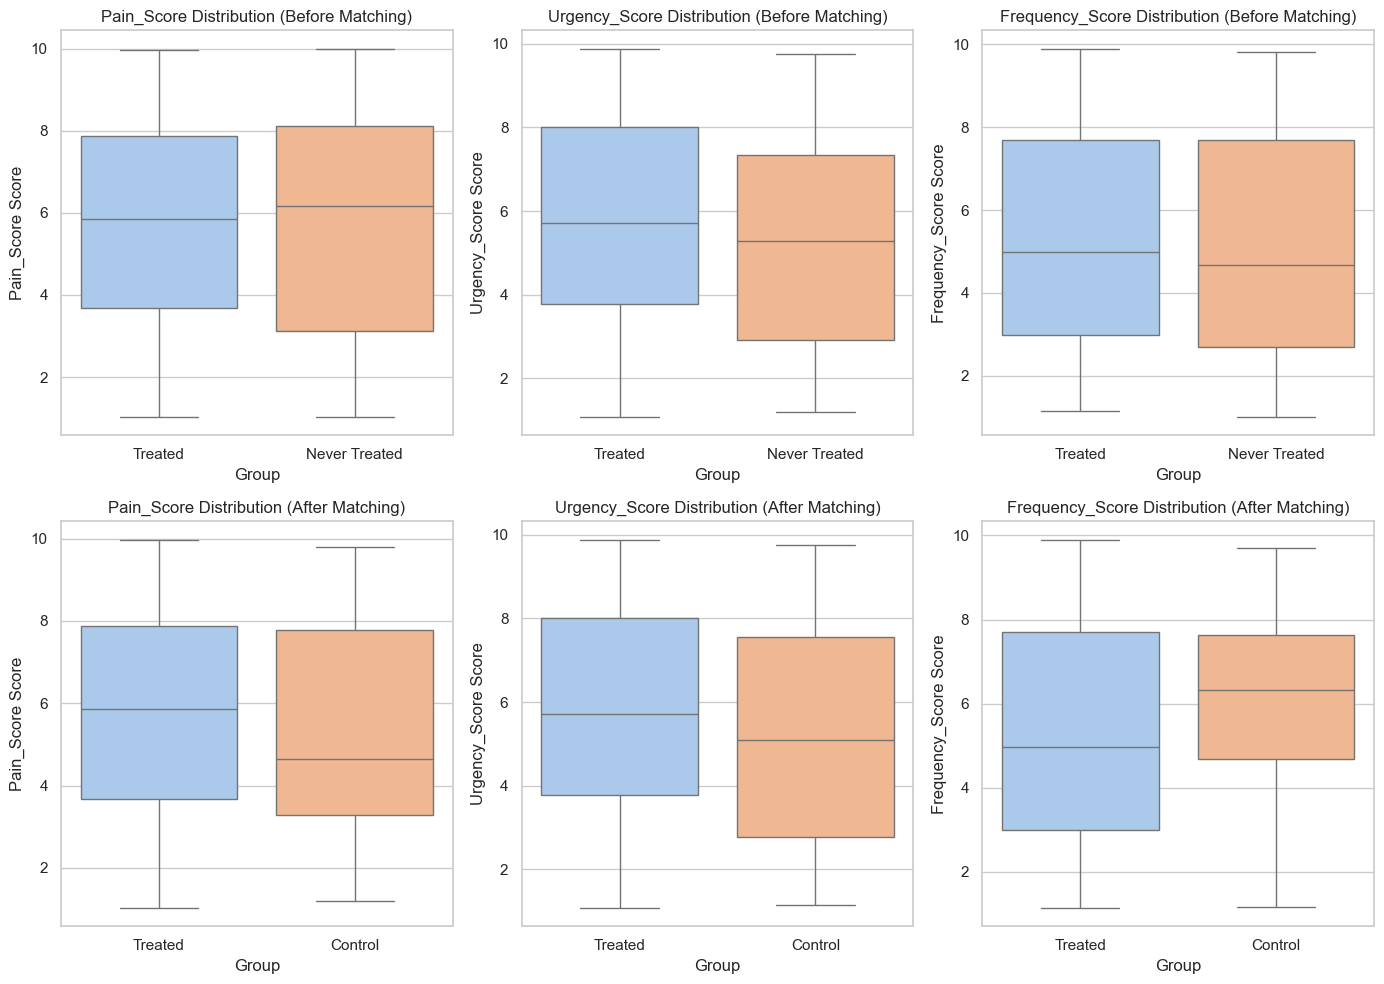

In [210]:
# Boxplots showing the distribution of symptoms before and after matching.

plt.figure(figsize=(14, 10))

# Before matching (treated vs never treated)
for i, symptom in enumerate(covariate_columns):
    plt.subplot(2, 3, i+1)
    sns.boxplot(data=[df[df['Treatment_Status'] == 1][symptom].values, df[df['Treatment_Status'] == 0][symptom].values], showfliers=False, palette="pastel")
    plt.xticks([0, 1], ["Treated", "Never Treated"])
    plt.title(f"{symptom} Distribution (Before Matching)")
    plt.xlabel("Group")
    plt.ylabel(f"{symptom} Score")

# After matching (treated vs control)
for i, symptom in enumerate(covariate_columns):
    plt.subplot(2, 3, i+4)
    sns.boxplot(data=[treated_matched[symptom].values, control_matched[symptom].values], showfliers=False, palette="pastel")
    plt.xticks([0, 1], ["Treated", "Control"])
    plt.title(f"{symptom} Distribution (After Matching)")
    plt.xlabel("Group")
    plt.ylabel(f"{symptom} Score")

plt.tight_layout()
plt.show()

<span style="color: #D5006D; font-size: 22px;">Step 6: Compute Treatment Effect</span>

In [213]:
# Now we will compare the changes in symptoms between treated and never treated 
def compute_treatment_effect(df, symptoms):
    results = {}
    for symptom in symptoms:
        treated_changes = df[df['Treatment_Status'] == 1][symptom]
        never_treated_changes = df[df['Treatment_Status'] == 0][symptom]
        
        # Perform Wilcoxon test on the unpaired data 
        stat, p_value = wilcoxon(treated_changes, never_treated_changes)
        results[symptom] = {
            "Mean Change (Treated)": treated_changes.mean(),
            "Mean Change (Never Treated)": never_treated_changes.mean(),
            "Wilcoxon Test Statistic": stat,
            "p-value": p_value
        }
    return pd.DataFrame(results).T

# Calculate treatment effects
effect_df = compute_treatment_effect(df, covariate_columns)
effect_df

,Mean Change (Treated),Mean Change (Never Treated),Wilcoxon Test Statistic,p-value
Pain_Score,5.699827,5.754555,2496.0,0.920573
Urgency_Score,5.727576,5.205994,2090.0,0.134739
Frequency_Score,5.240126,5.122664,2421.0,0.720653


<span style="color: #D5006D; font-size: 22px;">Step 7: Sensitivity Analysis</span>

In [217]:
# Perform a sensitivity analysis to check for hidden biases, comparing treated vs never treated

def sensitivity_analysis(df, matched_pairs):
    gamma_values = [1.0, 1.5, 2.0, 2.5, 3.0]
    
    # Ensure correct pairing using the matched pairs DataFrame
    treated_pain = df[df['Treatment_Status'] == 1].set_index('Patient_ID').loc[matched_pairs['Treated_ID'], 'Pain_Score'].values
    never_treated_pain = df[df['Treatment_Status'] == 0].set_index('Patient_ID').loc[matched_pairs['NeverTreated_ID'], 'Pain_Score'].values
    
    # Perform Wilcoxon test on the paired data
    stat, p_value = wilcoxon(treated_pain, never_treated_pain)
    
    # Adjust p-values based on different gamma levels
    results = {f"Gamma={gamma}": p_value * gamma for gamma in gamma_values}
    
    return pd.DataFrame(results, index=["Adjusted P-Value"]).T

# Run sensitivity analysis with matched pairs 
sensitivity_df = sensitivity_analysis(df, matched_pairs)
print(sensitivity_df)

           Adjusted P-Value
Gamma=1.0          0.369504
Gamma=1.5          0.554256
Gamma=2.0          0.739008
Gamma=2.5          0.923760
Gamma=3.0          1.108512


<span style="color: #D5006D; font-size: 22px;">Step 8: Visualizing Sensitivity Analysis Results</span>

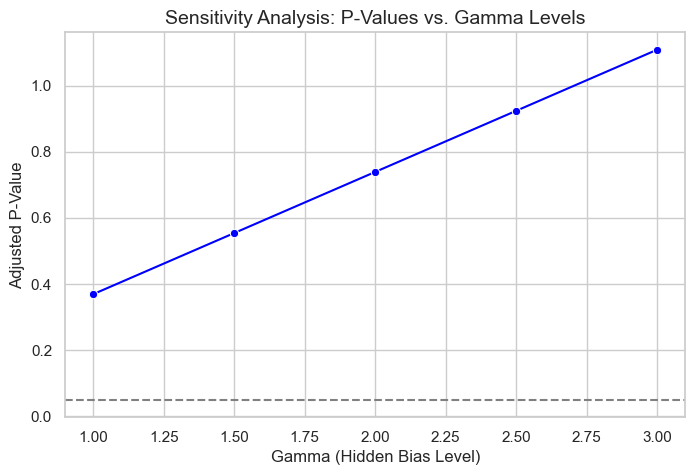

In [219]:
plt.figure(figsize=(8, 5))
sns.lineplot(x=[1.0, 1.5, 2.0, 2.5, 3.0], y=sensitivity_df["Adjusted P-Value"], marker="o", color="blue")
plt.axhline(y=0.05, color='gray', linestyle='dashed')
plt.title("Sensitivity Analysis: P-Values vs. Gamma Levels", fontsize=14)
plt.xlabel("Gamma (Hidden Bias Level)", fontsize=12)
plt.ylabel("Adjusted P-Value", fontsize=12)
plt.show()